In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time as ti
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint



Found 70491 files belonging to 141 classes.
Using 56393 files for training.
Found 70491 files belonging to 141 classes.
Using 14098 files for validation.
Found 23619 files belonging to 141 classes.
Input Shape: (100, 100, 3)
Number of Classes: 141


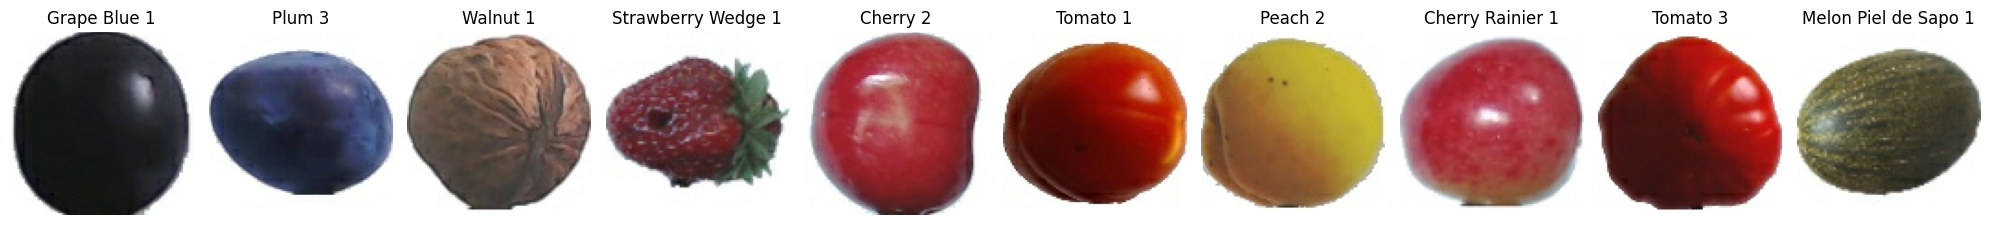

In [2]:
train_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training'
test_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Test'

img_size = (100, 100)
batch_size = 32

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    subset="training",
    validation_split=0.2,
    image_size=img_size,
    batch_size=batch_size,
    seed=250,
    shuffle=True,
)

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    subset="validation",
    validation_split=0.2,
    image_size=img_size,
    batch_size=batch_size,
    seed=60,
    shuffle=True,
)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False, 
    seed=60,
)

# Extract input shape
for images, labels in train_generator.take(1):
    input_shape = images.shape[1:]  # Exclude batch dimension
    break
print("Input Shape:", input_shape)

# Get class names
class_names = train_generator.class_names
num_classes = len(class_names)
print("Number of Classes:", num_classes)

# Calculate class distribution (count of labels)
# Aggregate labels from the dataset
label_counts = np.zeros(num_classes, dtype=int)
for _, labels in train_generator:
    label_counts += np.sum(tf.one_hot(labels, depth=num_classes).numpy().astype(int), axis=0)

# Sort classes by image count
sorted_indices = np.argsort(label_counts)[::-1]
top_classes = sorted_indices[:10]  # Top 10 classes
top_class_names = [class_names[i] for i in top_classes]

# Display one image for each top class
fig, axes = plt.subplots(1, 10, figsize=(20, 5))

for i, class_idx in enumerate(top_classes):
    for images, labels in train_generator:  # Iterate through dataset batches
        for img, label in zip(images, labels):
            if label == class_idx:
                axes[i].imshow(img.numpy().astype("uint8"))
                axes[i].axis('off')
                axes[i].set_title(top_class_names[i])
                break
        else:
            continue
        break

plt.tight_layout()
plt.show()


In [3]:
x_train = []
y_train = []

for images, labels in train_generator:
    x_train.append(images.numpy())  # Convert tensor to numpy array
    y_train.append(labels.numpy())  # Convert tensor to numpy array

x_train = np.concatenate(x_train, axis=0)  # Concatenate all image batches
y_train = np.concatenate(y_train, axis=0)  # Concatenate all label batches

# Print shapes of x_train and y_train
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Extracting x_test, y_test from test_generator
x_test = []
y_test = []

for images, labels in test_generator:
    x_test.append(images.numpy())  # Convert tensor to numpy array
    y_test.append(labels.numpy())  # Convert tensor to numpy array

x_test = np.concatenate(x_test, axis=0)  # Concatenate all image batches
y_test = np.concatenate(y_test, axis=0)  # Concatenate all label batches

# Print shapes of x_test and y_test
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (56393, 100, 100, 3)
y_train shape: (56393,)
x_test shape: (23619, 100, 100, 3)
y_test shape: (23619,)


In [5]:
class_names = train_generator.class_names

# Sort class names in ascending order
sorted_class_names = sorted(class_names)

print(f"Sorted Class Names: {sorted_class_names}")


Sorted Class Names: ['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple hit 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana Lady Finger 1', 'Banana Red 1', 'Beetroot 1', 'Blueberry 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1', 'Chestnut 1', 'Clementine 1', 'Cocos 1', 'Corn 1', 'Corn Husk 1', 'Cucumber 1', 'Cucumber 3', 'Cucumber Ripe 1', 'Cucumber Ripe 2', 'Dates 1', 'Eggplant 1', 'Eggplant long 1', 'Fig 1', 'Ginger Root 1', 'Granadilla 1', 'Grape Blue 1', 'Grape Pink 1', 'Grape White 1', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink 1', 'Grapefrui

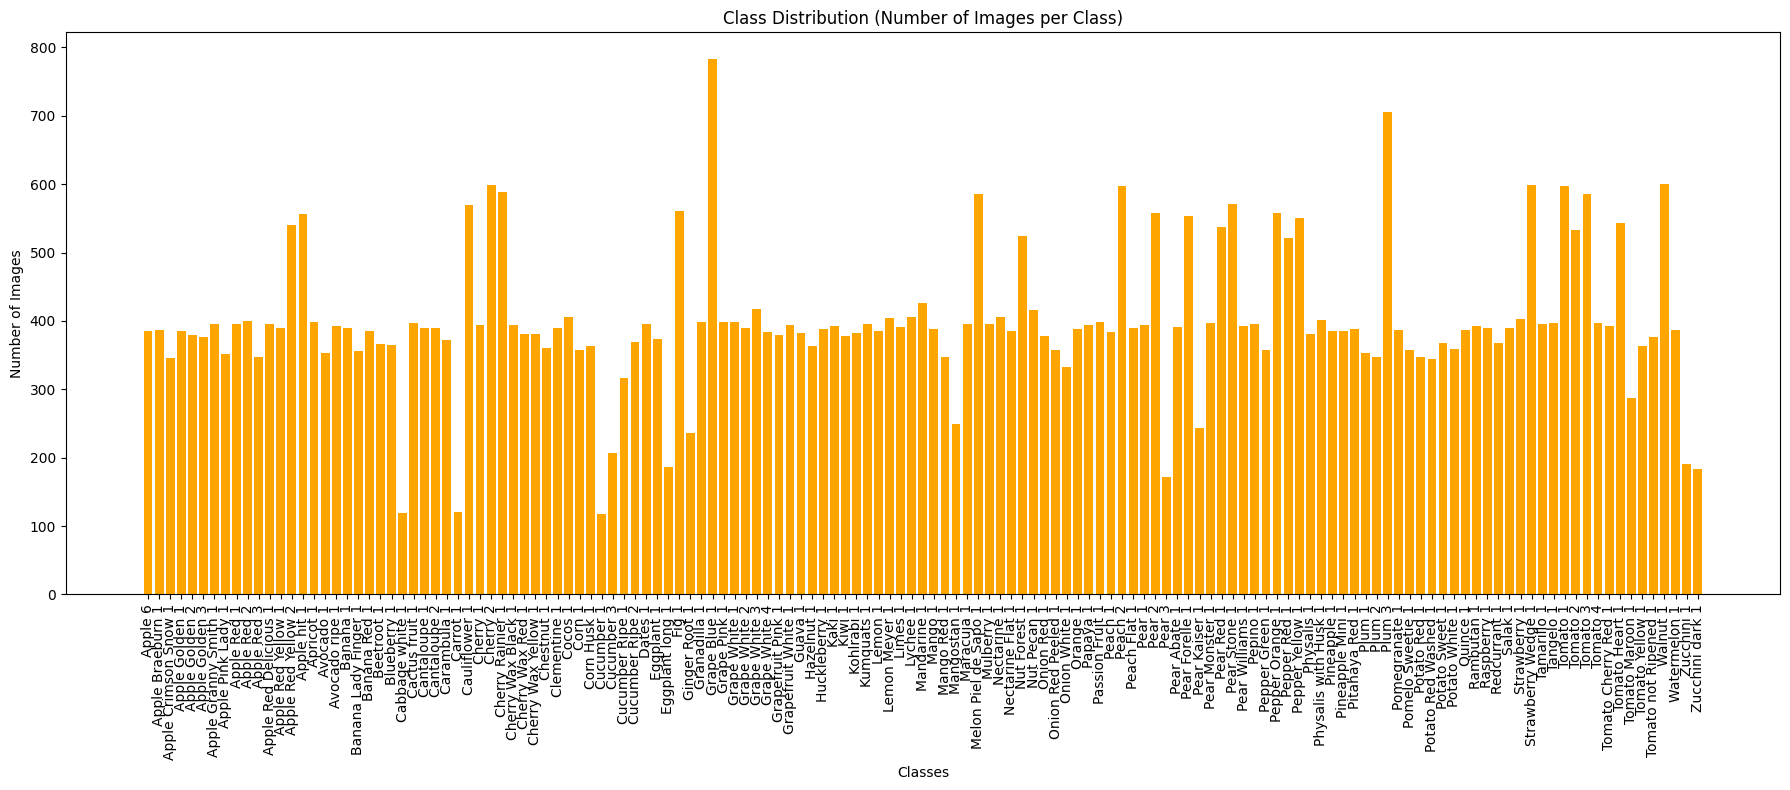

In [6]:
# Calculate the class distribution (i.e., how many samples per class)
class_counts = np.zeros(len(class_names), dtype=int)

# Count how many images there are for each class
for _, labels in train_generator:
    for label in labels:
        class_counts[label] += 1

# Create a bar graph
plt.figure(figsize=(18, 8))
plt.bar(class_names, class_counts, color='orange')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution (Number of Images per Class)')
plt.xticks(rotation=90)  # Rotate class names to avoid overlap

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
# V-CNN Versatile CNN model -
# includes L-CNN, NL-CNN and XNL-CNN as particular cases.
# The basic unit is the "macro-layer" as in the XNL-CNN but here one can independently choose the
# filter size (fil) and
# nonlinearity nl (0 means "linear" convolution)
# It allows any number of additional dense layers e.g. hid=[] (no hidden dense) or hid =[100, 100] (two additional).
# Copyright Radu and Ioana DOGARU - correspondence: radu.dogaru@upb.ro
# Last update June 21, 2023
#-------------------------------------------------------------------------------------------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling
from tensorflow.keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam

#--------------------------  ------------------------------
def create_v_cnn_model(input_shape, num_classes, flat=1, fil=[100,100,100,100], nl=[1,1,0,0], hid=[]):
    # Note the number of elements in fil list (macrolayers) should be the same in nl list
    # hid can be [] while if the are elements, additional dense layers are added in the output classifier

    csize=3; stri=2; psiz=4; pad='same';
    drop1=0.3

    nfilmax=np.shape(np.array(fil))[0]
    model = Sequential()
    # First macrolayer - connected to input  ----------------
    layer=0
    if nl[layer]>0:
        model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize), input_shape=input_shape ) )
        model.add(Activation('relu'))
        for nonlin in range(1,nl[0]):
            model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
            model.add(Activation('relu'))

        model.add(Conv2D(fil[0], padding=pad, kernel_size=(csize, csize) ) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))

    else:
        model.add(Conv2D(fil[0], padding=pad, kernel_size=(csize, csize), input_shape=input_shape ) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))
    # The remaining  macro-layers

    for layer in range(1,nfilmax):
        #------------------ nonlin layers -----------------
        for nonlin in range(nl[layer]):
            model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
            model.add(Activation('relu'))

        #----------------- default macrolayer output

        model.add(Conv2D(fil[layer], padding=pad, kernel_size=(csize, csize)) )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad))
        model.add(Dropout(drop1))

    # Exit classifier
    # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice )
    if flat==1:
        model.add(Flatten())  # alternanta cu GlobalAv ..
    elif flat==0:
        model.add(GlobalAveragePooling2D()) # pare sa fie mai Ok la cifar
    nhid=np.shape(np.array(hid))[0]
    if nhid>0:
        for lay in range(nhid):
            model.add(Dense(hid[lay], activation='relu'))
            #model.add(Dropout(drop1))
    model.add(Dense(num_classes, activation='softmax'))

# END OF MODEL DESCRIPTION
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [8]:
# create the V-CNN with specified parameters
model=create_v_cnn_model(input_shape, num_classes, flat=0, fil=[50,150,150,50], nl=[1,1,0,0], hid=[])
model.summary()
print(len(model.layers))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 50)   │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100, 100, 50)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 50)   │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 50)   │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 50, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 150)    │        67,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 50, 50, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 150)    │       202,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 150)    │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 25, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 25, 150)    │       202,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 25, 25, 150)    │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 50)     │        67,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 50)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 141)            │         7,191 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 573,241 (2.19 MB)

 Trainable params: 572,441 (2.18 MB)

 Non-trainable params: 800 (3.12 KB)

22


In [110]:

#def convert_to_one_hot(images, labels):
 #   return images, tf.one_hot(labels, depth=num_classes)

#train_generator = train_generator.map(convert_to_one_hot)
#validation_generator = validation_generator.map(convert_to_one_hot)
#test_generator = test_generator.map(convert_to_one_hot)  # Optional for evaluation


In [9]:
#checkpoint pentru a salva modelul cel mai bun
checkpoint = ModelCheckpoint(
    filepath='vcnn_model.keras',  # Path where the model will be saved
    monitor='val_accuracy',      # Metric to monitor
    save_best_only=True,         # Save only the best model
    mode='max',                  # Higher is better for validation accuracy
    verbose=1                    # Print when saving the best model
)

In [10]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

epoci = 10
t1=ti.time()   # save the time when training started

history = model.fit(
    x_train, y_train_one_hot,                # data set used for training
    epochs=epoci,                            # number of epochs  
    validation_data=(x_test, y_test_one_hot), # data used for validation
    batch_size=batch_size,                   # number of samples 
    verbose=2,                               # display just the number of epoch
    callbacks=[checkpoint]                   # what callback to use
)
   
t2=ti.time()   #save the time when training ended
print('====================================================')
print('Training with  ',epoci,' epochs, lasted  ',int(t2-t1)/60,' minutes')
t1=ti.time()   # save the time when the model started to load
model=load_model('vcnn_model.keras')  #load the best model saved during training
bp=model.get_weights()  # best weights set
score = model.evaluate(x_test, y_test_one_hot, verbose=0) #evaluate the model on the test data
t2=ti.time()   #save the time when the evaluation process ended
loss, accuracy = score  # Unpack the evaluation metrics
print(f"Total number of parameters: {model.count_params()}")
print(f"Best validation accuracy: {accuracy * 100:.2f}%")
print(f"Loss on test set: {loss:.4f}")
print(f"Time to predict on the entire test set: {t2 - t1:.2f} seconds")
print(f"Latency - GPU (per sample): {1000 * (t2 - t1) / np.shape(x_test)[0]:.2f} ms")

Epoch 1/10


I0000 00:00:1734362587.291038      93 service.cc:145] XLA service 0x7ee7cc0022b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734362587.291125      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734362598.304364      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.91642, saving model to vcnn_model.keras
1763/1763 - 94s - 53ms/step - accuracy: 0.7739 - loss: 1.1706 - val_accuracy: 0.9164 - val_loss: 0.3310
Epoch 2/10

Epoch 2: val_accuracy improved from 0.91642 to 0.95652, saving model to vcnn_model.keras
1763/1763 - 64s - 36ms/step - accuracy: 0.9852 - loss: 0.0923 - val_accuracy: 0.9565 - val_loss: 0.1304
Epoch 3/10

Epoch 3: val_accuracy improved from 0.95652 to 0.97460, saving model to vcnn_model.keras
1763/1763 - 65s - 37ms/step - accuracy: 0.9882 - loss: 0.0559 - val_accuracy: 0.9746 - val_loss: 0.1056
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.97460
1763/1763 - 64s - 36ms/step - accuracy: 0.9946 - loss: 0.0270 - val_accuracy: 0.9376 - val_loss: 0.1730
Epoch 5/10

Epoch 5: val_accuracy improved from 0.97460 to 0.98709, saving model to vcnn_model.keras
1763/1763 - 64s - 36ms/step - accuracy: 0.9928 - loss: 0.0290 - val_accuracy: 0.9871 - val_loss: 0.0564
Epoch 6/10

Epoch 6: val_ac

In [11]:
# salveaza modelul
model.save('vcnn.h5')  # save the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

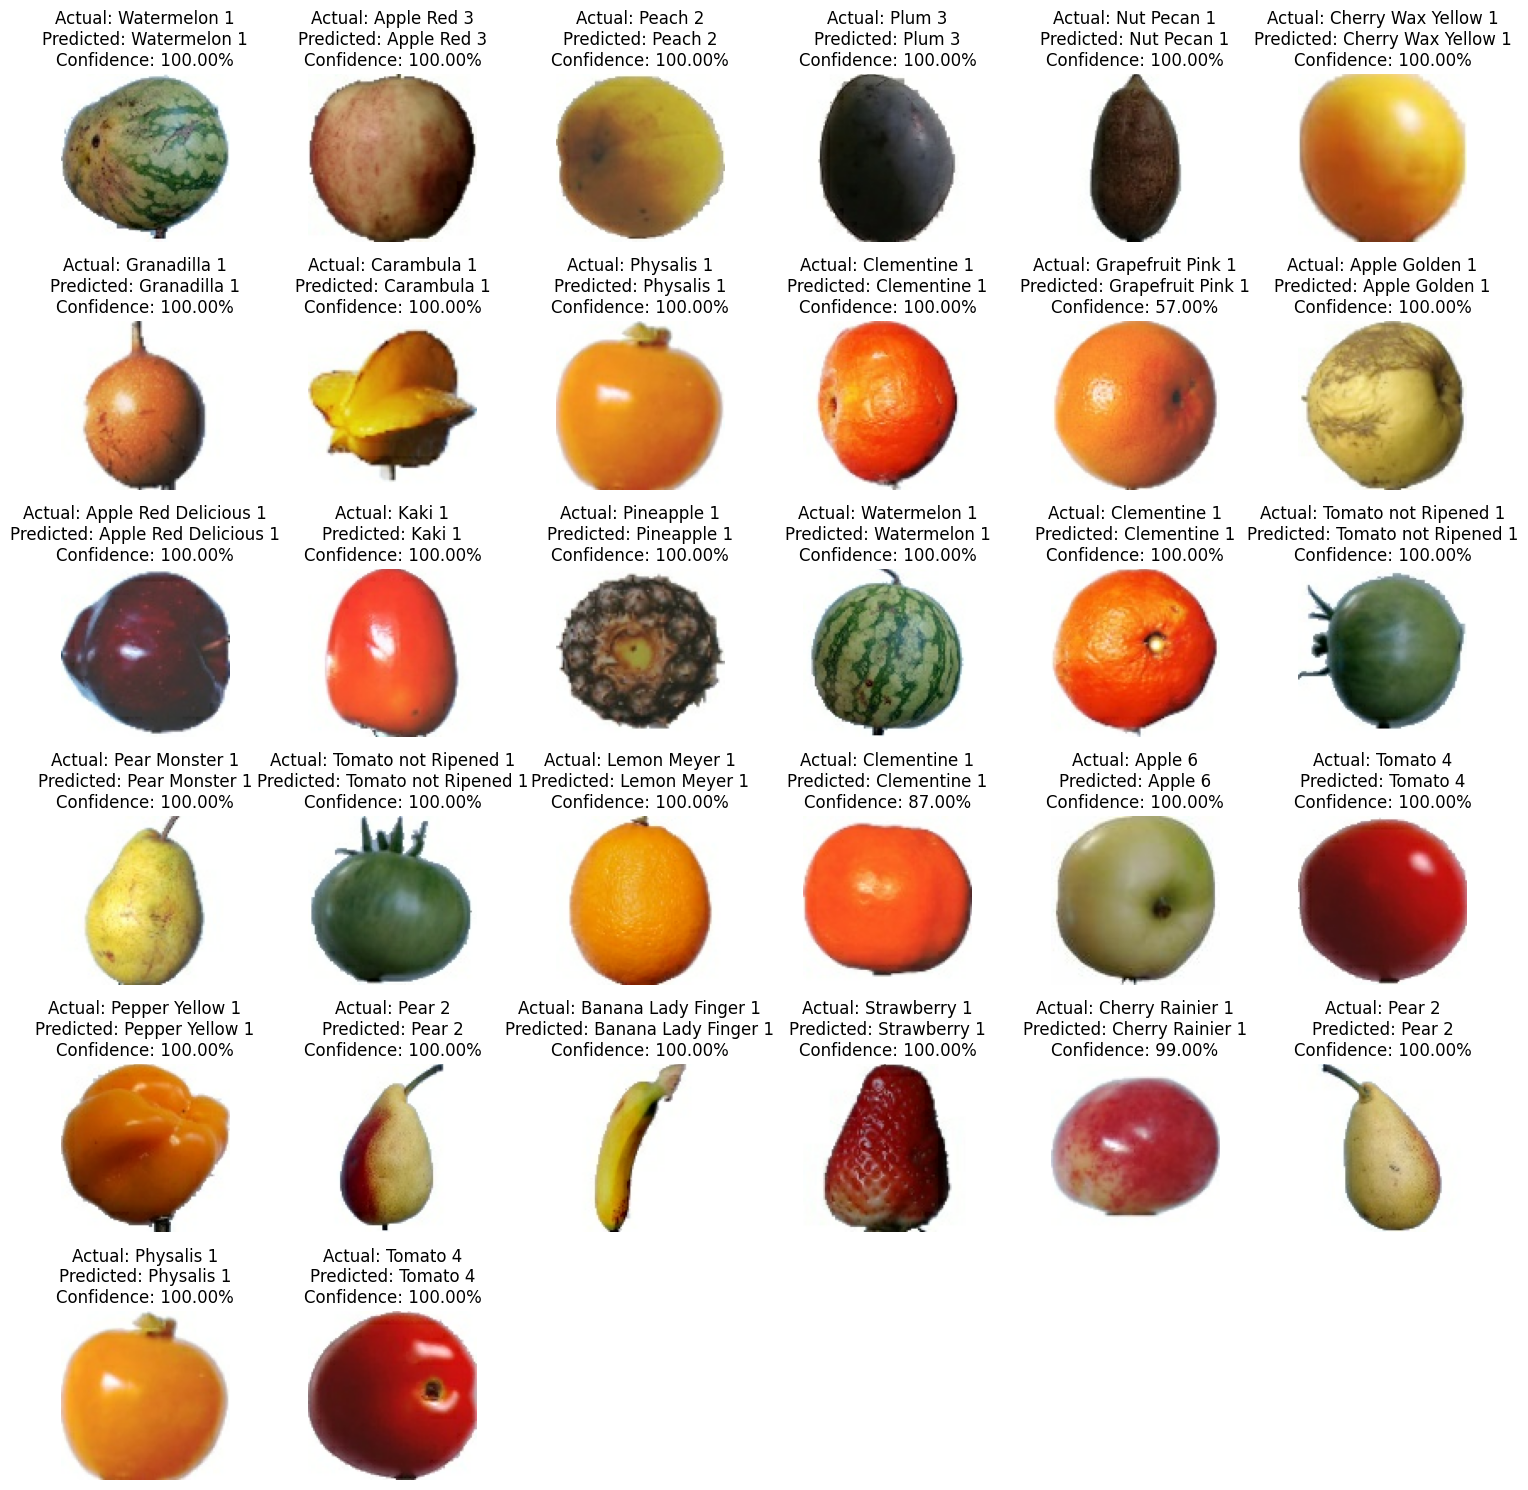

In [67]:
import matplotlib.pyplot as plt

def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence
    
# Assuming val_ds is your validation dataset
plt.figure(figsize=(15, 15))
for images, labels in validation_generator.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i+1)  # Adjust the subplot layout as per your preference
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the imag

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%")

        plt.axis('off')

plt.tight_layout()
plt.show()


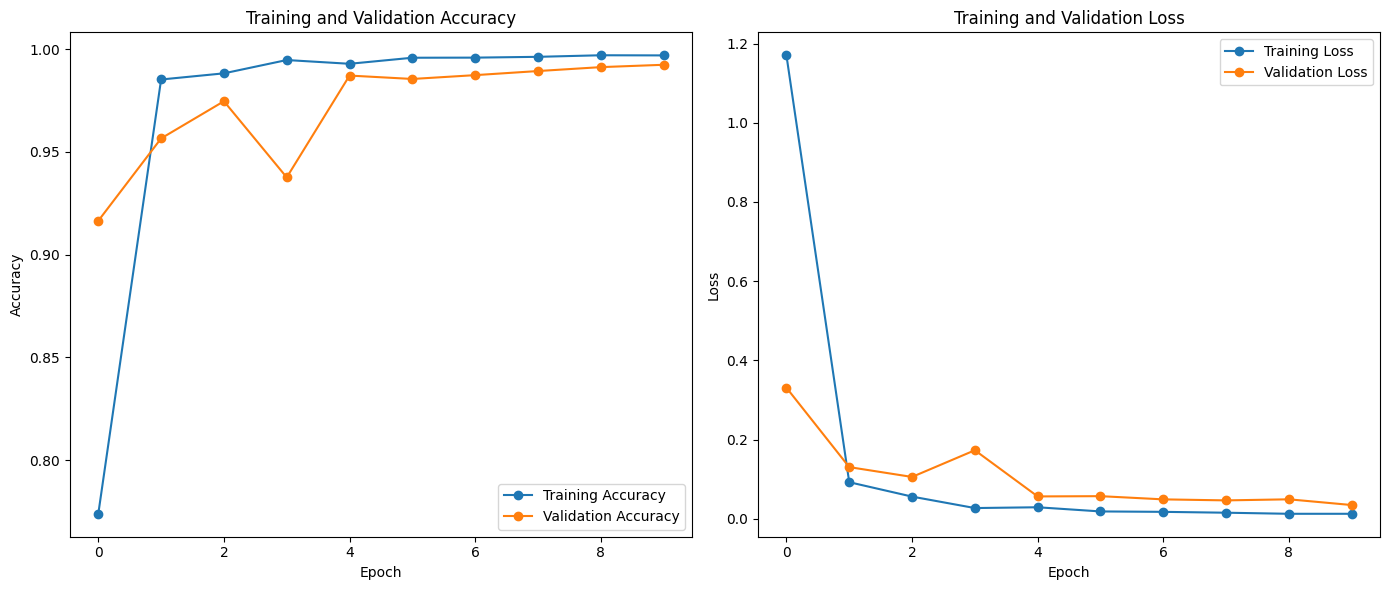

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend()

# Plot Loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [20]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

# Necesar in Keras 3 pentru compatibilizare cu formatul TF 
# exporta in format tf export 
model = load_model('vcnn_model.keras')
model.export('some', format="fruits-VCNN.tflite")
# # incarca modelul exportat 
import tensorflow as tf 
mod=tf.saved_model.load('some')

Saved artifact at 'some'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 141), dtype=tf.float32, name=None)
Captures:
  139536803336912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803340608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803375312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803379008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803401040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803397696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803399280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803399456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803411072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803413360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139536803532816: Tensor

In [21]:
# conversie tf.lite 
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI UNST Politehnica Bucuresti 

converter = tf.lite.TFLiteConverter.from_keras_model(mod)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
# may be useful : https://medium.com/@hellokhorshed/a-step-by-step-guide-to-convert-keras-model-to-tensorflow-lite-tflite-model-6c8d08707488
# se pot incerca diverse formule de cuantizare de ex. cea de mai jos 
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Salvarea modelului TensorFlow Lite într-un fișier
#tflite_file = f'{model_name}_{dataset}.tflite'
tflite_file='fruits-VCNN.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

print("Conversia a fost realizată cu succes și modelul a fost salvat ca: ",tflite_file)

Conversia a fost realizată cu succes și modelul a fost salvat ca:  fruits-VCNN.tflite


W0000 00:00:1734364296.875883      23 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1734364296.875906      23 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [22]:
import numpy as np
import tensorflow as tf
import time as ti
from sklearn.metrics import classification_report, confusion_matrix

out_coding = 'cat'  # Helper function, run once

def evaluate_model(interpreter, x_test, y_test):  # num_batches only if you use validation_generator
    # Check if y_test is one-hot encoded or already in class indices
    if y_test.ndim == 2:  # If y_test is one-hot encoded (shape: [num_samples, num_classes])
        ync_test = np.argmax(y_test, axis=1)  # Convert to class indices
    else:  # If y_test is already in class indices (shape: [num_samples])
        ync_test = y_test  # Use it as is
    
    # Get input and output details for the interpreter
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    prediction_digits = []
    durata = 0
    
    # Loop through test images
    for test_image in x_test:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)  # Reshape if necessary
        interpreter.set_tensor(input_index, test_image)
        
        t1 = ti.time()
        # Run inference
        interpreter.invoke()
        t2 = ti.time()
        durata += (t2 - t1)
        
        output = interpreter.get_tensor(output_index)  # Get output from the interpreter
        digit = np.argmax(output, axis=1)  # Convert to predicted class (index)
        prediction_digits.append(digit)

    # Confusion matrix and accuracy calculation
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == ync_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)
    
    # Confusion matrix
    C = confusion_matrix(prediction_digits, ync_test)
    print(C)
    print(classification_report(ync_test, prediction_digits))
    
    return accuracy, prediction_digits, 1000 * durata / len(prediction_digits)  # Return accuracy, predictions, and latency

In [24]:
# absolut necesare pentru a se putea lucra mai departe 
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/fruits-VCNN.tflite' )  # 
interpreter.allocate_tensors()

In [25]:
# Assuming you have x_test and y_test prepared correctly
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/fruits-VCNN.tflite' )

interpreter.allocate_tensors()
print("Model Sizes:")
!ls -lh | awk '{print $5 "\t" $9}'  # List model size (optional)
# Evaluate the .tflite model
acc, pred, lat = evaluate_model(interpreter, x_test, y_test)
print(f'Validation accuracy on .tflite model is: {100*acc:.2f}%', f'Latency: {lat:.2f} ms')

Model Sizes:


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


	
574K	fruits-VCNN
574K	fruits-VCNN.tflite
4.0K	some
6.7M	vcnn.h5
6.7M	vcnn_model.keras
[[157   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 148 ...   0   0   0]
 ...
 [  0   0   0 ... 157   0   0]
 [  0   0   0 ...   0  80   0]
 [  0   0   0 ...   0   0  80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       164
           2       1.00      1.00      1.00       148
           3       1.00      1.00      1.00       160
           4       1.00      1.00      1.00       164
           5       1.00      1.00      1.00       161
           6       1.00      1.00      1.00       164
           7       1.00      1.00      1.00       152
           8       1.00      1.00      1.00       164
           9       1.00      1.00      1.00       164
          10       1.00      1.00      1.00       144
          11       1.00      1.00      1.00       166
          12     

In [2]:
#Adaptat dupa - https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False, 
    input_shape=(100, 100, 3),
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
from tensorflow.keras import layers, models

model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),  # Regularization
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model2.fit(
    train_generator,
    epochs=7,
    steps_per_epoch=len(train_generator)
)

test_loss, test_acc = model2.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/7


I0000 00:00:1739204647.995004      94 service.cc:145] XLA service 0x7c8e30012ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739204647.995089      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  10/1763 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.0031 - loss: 5.0248      

I0000 00:00:1739204666.317745      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1763/1763 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.3647 - loss: 3.4723
Epoch 2/7
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/7
  10/1763 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8986 - loss: 1.0573

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1763/1763 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8949 - loss: 0.9478
Epoch 4/7
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/7
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9457 - loss: 0.4927
Epoch 6/7
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/7
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9642 - loss: 0.3138
739/739 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9076 - loss: 0.4472
Test Accuracy: 0.92


In [13]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

# Necesar in Keras 3 pentru compatibilizare cu formatul TF 
# exporta in format tf export 
model2.export('some', format="fruits-EfficientNet.tflite")
# # incarca modelul exportat 
import tensorflow as tf 
mod=tf.saved_model.load('some')

Saved artifact at 'some'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 141), dtype=tf.float32, name=None)
Captures:
  136950271606128: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136950271595920: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136950271593632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136950271481408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136950271480704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136950271590816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136950271479120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136950271483520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136950271480000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136950271488448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

In [14]:
# conversie tf.lite 
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI UNST Politehnica Bucuresti 

converter = tf.lite.TFLiteConverter.from_keras_model(mod)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
# may be useful : https://medium.com/@hellokhorshed/a-step-by-step-guide-to-convert-keras-model-to-tensorflow-lite-tflite-model-6c8d08707488
# se pot incerca diverse formule de cuantizare de ex. cea de mai jos 
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Salvarea modelului TensorFlow Lite într-un fișier
#tflite_file = f'{model_name}_{dataset}.tflite'
tflite_file='fruits-EfficientNet.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

print("Conversia a fost realizată cu succes și modelul a fost salvat ca: ",tflite_file)

W0000 00:00:1739204943.434737      23 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1739204943.434772      23 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Conversia a fost realizată cu succes și modelul a fost salvat ca:  fruits-EfficientNet.tflite


In [15]:
import numpy as np
import tensorflow as tf
import time as ti
from sklearn.metrics import classification_report, confusion_matrix

out_coding = 'cat'  # Helper function, run once

def evaluate_model(interpreter, x_test, y_test):  # num_batches only if you use validation_generator
    # Check if y_test is one-hot encoded or already in class indices
    if y_test.ndim == 2:  # If y_test is one-hot encoded (shape: [num_samples, num_classes])
        ync_test = np.argmax(y_test, axis=1)  # Convert to class indices
    else:  # If y_test is already in class indices (shape: [num_samples])
        ync_test = y_test  # Use it as is
    
    # Get input and output details for the interpreter
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    prediction_digits = []
    durata = 0
    
    # Loop through test images
    for test_image in x_test:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)  # Reshape if necessary
        interpreter.set_tensor(input_index, test_image)
        
        t1 = ti.time()
        # Run inference
        interpreter.invoke()
        t2 = ti.time()
        durata += (t2 - t1)
        
        output = interpreter.get_tensor(output_index)  # Get output from the interpreter
        digit = np.argmax(output, axis=1)  # Convert to predicted class (index)
        prediction_digits.append(digit)

    # Confusion matrix and accuracy calculation
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == ync_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)
    
    # Confusion matrix
    C = confusion_matrix(prediction_digits, ync_test)
    print(C)
    print(classification_report(ync_test, prediction_digits))
    
    return accuracy, prediction_digits, 1000 * durata / len(prediction_digits)  # Return accuracy, predictions, and latency

In [16]:
# absolut necesare pentru a se putea lucra mai departe 
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/fruits-EfficientNet.tflite' )  # 
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [17]:
# Assuming you have x_test and y_test prepared correctly
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/fruits-EfficientNet.tflite' )

interpreter.allocate_tensors()
print("Model Sizes:")
!ls -lh | awk '{print $5 "\t" $9}'  # List model size (optional)
# Evaluate the .tflite model
acc, pred, lat = evaluate_model(interpreter, x_test, y_test)
print(f'Validation accuracy on .tflite model is: {100*acc:.2f}%', f'Latency: {lat:.2f} ms')

Model Sizes:


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


	
4.6M	fruits-EfficientNet.tflite
4.0K	some
[[156   0   0 ...   0   0   0]
 [  0 160   0 ...   0   0   0]
 [  0   0  89 ...   0   0   0]
 ...
 [  0   0   0 ... 157   0   0]
 [  0   0   0 ...   0  80   0]
 [  0   0   0 ...   0   0  80]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       157
           1       0.66      0.98      0.79       164
           2       0.75      0.60      0.67       148
           3       0.95      0.99      0.97       160
           4       0.80      0.63      0.70       164
           5       0.55      0.99      0.71       161
           6       0.94      0.71      0.81       164
           7       0.82      0.53      0.64       152
           8       0.64      0.87      0.74       164
           9       0.60      0.63      0.61       164
          10       0.81      0.61      0.70       144
          11       1.00      1.00      1.00       166
          12       0.94      0.97      0.95       164
       

In [3]:
#Adaptat dupa https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(100, 100, 3),  # Match your image size
    include_top=False,         # Exclude final Dense layer
    weights='imagenet'         # Use pre-trained ImageNet weights
)
base_model.trainable = True  # Freeze the base model

/tmp/ipykernel_23/360804820.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model3 = models.Sequential([
    base_model,                          # Pre-trained MobileNetV2
    layers.GlobalAveragePooling2D(),     # Global pooling to reduce dimensions
    layers.Dropout(0.5),                 # Add dropout for regularization
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Train
history = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
)

# Evaluate
test_loss, test_acc = model3.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/15
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 109s 42ms/step - accuracy: 0.8138 - loss: 0.7995 - val_accuracy: 0.0434 - val_loss: 20.6879
Epoch 2/15
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.9715 - loss: 0.0990 - val_accuracy: 0.1275 - val_loss: 20.7963
Epoch 3/15
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.9784 - loss: 0.0792 - val_accuracy: 0.6030 - val_loss: 3.6570
Epoch 4/15
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.9837 - loss: 0.0590 - val_accuracy: 0.7329 - val_loss: 2.1959
Epoch 5/15
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 55s 31ms/step - accuracy: 0.9849 - loss: 0.0538 - val_accuracy: 0.7222 - val_loss: 2.2007
Epoch 6/15
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.9899 - loss: 0.0340 - val_accuracy: 0.8145 - val_loss: 1.3930
Epoch 7/15
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.9871 - loss: 0.0444 - val_accuracy: 0.7122 - val_loss: 3.0138
Epoch 8/15
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.987

In [15]:
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI si NA UNST Politehnica Bucuresti 

# Necesar in Keras 3 pentru compatibilizare cu formatul TF 
# exporta in format tf export 
model3.export('some', format="mobmob.tflite")
# # incarca modelul exportat 
import tensorflow as tf 
mod=tf.saved_model.load('some')

Saved artifact at 'some'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_626')
Output Type:
  TensorSpec(shape=(None, 141), dtype=tf.float32, name=None)
Captures:
  138398509247552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499450624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499451152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499449040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499450976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499884016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499882432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499888944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499885776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499887360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138398499893520: Ten

In [16]:
# conversie tf.lite 
# Copyright Radu and Ioana Dogaru, contact radu.dogaru@upb.ro suport curs ICI UNST Politehnica Bucuresti 

converter = tf.lite.TFLiteConverter.from_keras_model(mod)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
# may be useful : https://medium.com/@hellokhorshed/a-step-by-step-guide-to-convert-keras-model-to-tensorflow-lite-tflite-model-6c8d08707488
# se pot incerca diverse formule de cuantizare de ex. cea de mai jos 
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Salvarea modelului TensorFlow Lite într-un fișier
#tflite_file = f'{model_name}_{dataset}.tflite'
tflite_file='mobmob.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

print("Conversia a fost realizată cu succes și modelul a fost salvat ca: ",tflite_file)

Conversia a fost realizată cu succes și modelul a fost salvat ca:  mobmob.tflite


W0000 00:00:1740242778.176078      23 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1740242778.176117      23 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


In [17]:
import numpy as np
import tensorflow as tf
import time as ti
from sklearn.metrics import classification_report, confusion_matrix

out_coding = 'cat'  # Helper function, run once

def evaluate_model(interpreter, x_test, y_test):  # num_batches only if you use validation_generator
    # Check if y_test is one-hot encoded or already in class indices
    if y_test.ndim == 2:  # If y_test is one-hot encoded (shape: [num_samples, num_classes])
        ync_test = np.argmax(y_test, axis=1)  # Convert to class indices
    else:  # If y_test is already in class indices (shape: [num_samples])
        ync_test = y_test  # Use it as is
    
    # Get input and output details for the interpreter
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    prediction_digits = []
    durata = 0
    
    # Loop through test images
    for test_image in x_test:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)  # Reshape if necessary
        interpreter.set_tensor(input_index, test_image)
        
        t1 = ti.time()
        # Run inference
        interpreter.invoke()
        t2 = ti.time()
        durata += (t2 - t1)
        
        output = interpreter.get_tensor(output_index)  # Get output from the interpreter
        digit = np.argmax(output, axis=1)  # Convert to predicted class (index)
        prediction_digits.append(digit)

    # Confusion matrix and accuracy calculation
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == ync_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_digits)
    
    # Confusion matrix
    C = confusion_matrix(prediction_digits, ync_test)
    print(C)
    print(classification_report(ync_test, prediction_digits))
    
    return accuracy, prediction_digits, 1000 * durata / len(prediction_digits)  # Return accuracy, predictions, and latency

In [18]:
# absolut necesare pentru a se putea lucra mai departe 
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/mobmob.tflite' )  # 
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Assuming you have x_test and y_test prepared correctly
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/mobmob.tflite' )

interpreter.allocate_tensors()
print("Model Sizes:")
!ls -lh | awk '{print $5 "\t" $9}'  # List model size (optional)
# Evaluate the .tflite model
acc, pred, lat = evaluate_model(interpreter, x_test, y_test)
print(f'Validation accuracy on .tflite model is: {100*acc:.2f}%', f'Latency: {lat:.2f} ms')

Model Sizes:


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


	
2.6M	mobmob.tflite
4.0K	some
[[157   0   0 ...   0   0   0]
 [  0 108   0 ...   0   0   0]
 [  0   0  93 ...   0   0   0]
 ...
 [  0   0   0 ... 157   0   0]
 [  0   0   0 ...   0  80   0]
 [  0   0   0 ...   0   0  80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      0.66      0.79       164
           2       1.00      0.63      0.77       148
           3       0.94      1.00      0.97       160
           4       1.00      1.00      1.00       164
           5       0.99      0.94      0.96       161
           6       0.92      1.00      0.96       164
           7       0.98      0.94      0.96       152
           8       0.99      0.99      0.99       164
           9       0.73      1.00      0.84       164
          10       0.90      1.00      0.95       144
          11       0.98      1.00      0.99       166
          12       1.00      1.00      1.00       164
          13       1